In [ ]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [ ]:
import torch
from src.model import vgg_config, make_vgg_base, extractor_layers, make_multibox_layer, SSD
phase = 'train'
base = make_vgg_base()
extras = extractor_layers([], i=1024)
num_classes = 21
device = 'cuda' if torch.cuda.is_available() else 'cpu'
head = make_multibox_layer(base, extras, [4, 6, 6, 6, 4, 4], num_classes)
model = SSD(phase, base, extras, head, num_classes).to(device)
print(f'Num of parameters: {sum(p.numel() for p in model.parameters())}')

Num of parameters: 26285486


In [ ]:
import os
import sys
import torch
import torch.utils.data as data
import cv2
import numpy as np
import xml.etree.ElementTree as ET

BATCH_SIZE = 4
IMG_SIZE = 300

VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

class_to_ind = dict(zip(VOC_CLASSES, range(len(VOC_CLASSES))))

class BaseTransform:
    def __init__(self, size, mean):
        self.size = size
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        # 1. Resize image
        x = cv2.resize(image, (self.size, self.size)).astype(np.float32)
        # 2. Subtract mean (standard SSD preprocessing)
        x -= self.mean
        # 3. Convert to float tensor
        return x, boxes, labels

class VOCDetection(data.Dataset):
    def __init__(self, root, image_sets, transform=None):
        self.root = root
        self.image_set_index = image_sets
        self.transform = transform
        self._annopath = os.path.join('%s', 'Annotations', '%s.xml')
        self._imgpath = os.path.join('%s', 'JPEGImages', '%s.jpg')
        self.ids = list()
        
        for (year, name) in image_sets:
            rootpath = os.path.join(self.root, 'VOC' + year)
            # Check if file exists to avoid immediate crash
            list_file = os.path.join(rootpath, 'ImageSets', 'Main', name + '.txt')
            if not os.path.exists(list_file):
                print(f"Warning: Could not find {list_file}")
                continue
                
            for line in open(list_file):
                self.ids.append((rootpath, line.strip()))

    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        
        # separate boxes and labels
        boxes = [x[:4] for x in gt]
        labels = [x[4] for x in gt]
        
        # resize/transform
        if self.transform is not None:
            im, boxes, labels = self.transform(im, boxes, labels)
            
        # convert to tensor (channel First: 3, 300, 300)
        im = torch.from_numpy(im).permute(2, 0, 1)
        # keep them as a list of list because number of objects varies
        targets = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        return im, targets

    def __len__(self):
        return len(self.ids)

    def pull_item(self, index):
        img_id = self.ids[index]
        target = ET.parse(self._annopath % img_id).getroot()
        img = cv2.imread(self._imgpath % img_id)
        
        if img is None:
            raise FileNotFoundError(f"Could not find image: {self._imgpath % img_id}")

        height, width, channels = img.shape

        res = []
        for obj in target.iter('object'):
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text) - 1
                # Scale to 0-1
                cur_pt = cur_pt / width if i % 2 == 0 else cur_pt / height
                bndbox.append(cur_pt)
            
            label_idx = class_to_ind[name]
            label_idx += 1
            bndbox.append(label_idx)
            res.append(bndbox)
            
        return img, res, height, width

def detection_collate(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    return torch.stack(imgs, 0), targets

In [ ]:
voc_root = "data/VOCdevkit"
transform = BaseTransform(IMG_SIZE, (104, 117, 123))
BATCH_SIZE = 12
dataset = VOCDetection(root=voc_root, 
                        image_sets=[('2007', 'trainval')], 
                        transform=transform)

data_loader = data.DataLoader(dataset, 
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                collate_fn=detection_collate)


In [58]:
model = model.to(device)

In [59]:
from loss_fn.prior_box import voc, PriorBox
prior_box_gen = PriorBox(voc)
prior_box = prior_box_gen.forward()

In [60]:
prior_box = prior_box.to(device)

In [61]:
import torch.optim as optim
from loss_fn.loss_fn import CustomMultiBoxLoss
optimizer = optim.AdamW(model.parameters(),lr=1e-4, weight_decay=1e-5)
loss_fn = CustomMultiBoxLoss(threshold=0.5,
                             priors=prior_box,
                             conf_weight=40)

In [ ]:
from tqdm import tqdm
NUM_EPOCHS = 90
train_loc_losses = []
train_conf_losses = []
loop = tqdm(range(NUM_EPOCHS))
for i in loop:
    model.train()
    train_loc_loss, train_conf_loss, train_total_loss = 0.0, 0.0, 0.0
    for datas, targets in data_loader:
        #clear gradients
        optimizer.zero_grad()
        
        datas = datas.to(device)
        
        #inference
        loc, conf = model(datas)
        
        loc_loss, conf_loss = loss_fn((loc, conf), targets)
        train_loc_loss += loc_loss.item()
        train_conf_loss += conf_loss.item()
        
        total_loss = loc_loss + conf_loss
        train_total_loss += total_loss.item()
        #update
        total_loss.backward()
        optimizer.step()
    train_loc_loss /= len(data_loader)
    train_conf_loss /= len(data_loader)
    train_total_loss /= len(data_loader)
    train_loc_losses.append(train_loc_loss)
    train_conf_losses.append(train_conf_loss)
    
    loop.set_description(f'EPOCH [{i+1}|{NUM_EPOCHS}]: loc_loss: {train_loc_loss:.4f}, conf_loss: {train_conf_loss:.4f}| total_loss: {train_total_loss:.4f}')
    if (i + 1) % 5 == 0:
        torch.save(model.state_dict(), f"model_weights/ssd300_epoch_{i+1}.pth")
        


EPOCH [90|90]: loc_loss: 0.9965, conf_loss: 0.1422| total_loss: 1.1388: 100%|██████████| 10/10 [24:34<00:00, 147.47s/it]


In [103]:
import torch

def decode_boxes(loc, priors, variances=[0.1, 0.2]):
    """
    Decodes the predicted offsets into (xmin, ymin, xmax, ymax) coordinates.
    
    Args:
        loc: (tensor) Predicted offsets from the model. Shape: [num_priors, 4]
        priors: (tensor) Prior/Anchor boxes in (cx, cy, w, h) format. Shape: [num_priors, 4]
        variances: (list) Variance values used during encoding. Default: [0.1, 0.2]
    """
    # Ensure priors match the device of the location predictions
    priors = priors.to(loc.device)

    # 1. Decode center coordinates (cx, cy) and size (w, h)
    # cx = prior_cx + (loc_cx * var[0] * prior_w)
    # cy = prior_cy + (loc_cy * var[0] * prior_h)
    boxes_cx = priors[:, 0] + (loc[:, 0] * variances[0] * priors[:, 2])
    boxes_cy = priors[:, 1] + (loc[:, 1] * variances[0] * priors[:, 3])

    # w = prior_w * exp(loc_w * var[1])
    # h = prior_h * exp(loc_h * var[1])
    boxes_w = priors[:, 2] * torch.exp(loc[:, 2] * variances[1])
    boxes_h = priors[:, 3] * torch.exp(loc[:, 3] * variances[1])

    # 2. Convert (cx, cy, w, h) -> (xmin, ymin, xmax, ymax)
    boxes_xmin = boxes_cx - (boxes_w / 2)
    boxes_ymin = boxes_cy - (boxes_h / 2)
    boxes_xmax = boxes_cx + (boxes_w / 2)
    boxes_ymax = boxes_cy + (boxes_h / 2)

    return torch.stack([boxes_xmin, boxes_ymin, boxes_xmax, boxes_ymax], dim=1)

# AI plot

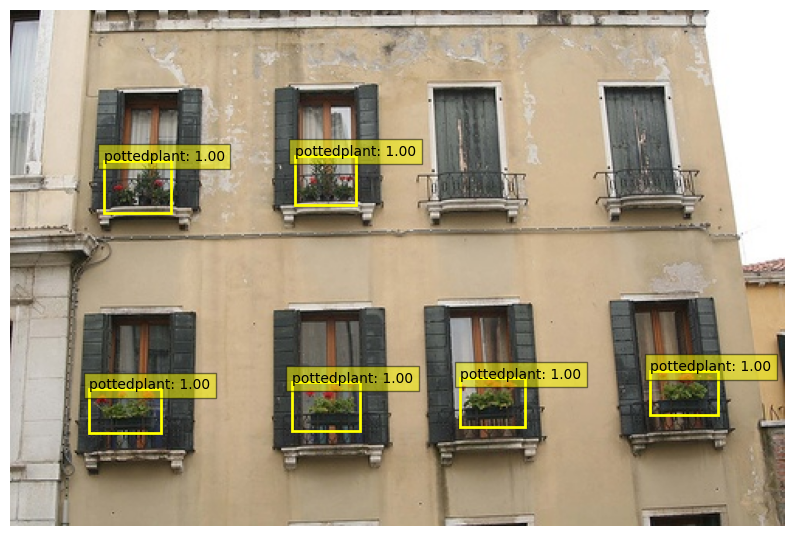

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
import cv2
import numpy as np
TEST_IMAGE_PATH = "data/VOCdevkit/VOC2007/JPEGImages/000052.jpg"

def predict_and_plot(image_path, ax=None):
    """
    Performs inference and plots result.
    If 'ax' is provided, plots on that axis.
    If 'ax' is None, creates a new standalone figure.
    """
    model.eval()
    
    # load and Preprocess
    orig_img = cv2.imread(image_path)
    if orig_img is None: 
        print(f"Image not found: {image_path}")
        return

    h_orig, w_orig, _ = orig_img.shape
    img = cv2.resize(orig_img, (300, 300)).astype(np.float32)
    img -= (104, 117, 123) 
    x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        loc_preds, conf_preds = model(x)
    
    loc_preds = loc_preds[0]
    conf_preds = torch.nn.functional.softmax(conf_preds[0], dim=1)

    # decode
    boxes = decode_boxes(loc_preds, prior_box) 
    boxes.clamp_(min=0, max=1)

    # 4. Handle Plotting Canvas
    show_plot = False
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
        show_plot = True

    # bgr -> rgb
    ax.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    
    for class_idx in range(1, 21):
        score_mask = conf_preds[:, class_idx] > 0.5 
        
        if not score_mask.any():
            continue
            
        class_boxes = boxes[score_mask]
        class_scores = conf_preds[score_mask, class_idx]
        
        keep_indices = torchvision.ops.nms(class_boxes, class_scores, 0.45)
        final_boxes = class_boxes[keep_indices]
        final_scores = class_scores[keep_indices]

        for box, score in zip(final_boxes, final_scores):
            box = box.cpu().numpy()
            
            xmin = box[0] * w_orig
            ymin = box[1] * h_orig
            xmax = box[2] * w_orig
            ymax = box[3] * h_orig
            
            w_box = xmax - xmin
            h_box = ymax - ymin
            
            rect = patches.Rectangle((xmin, ymin), w_box, h_box, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)
            
            # --- FIX: [class_idx - 1] ---
            # Model classes are 1-20, List indices are 0-19
            label_text = f"{VOC_CLASSES[class_idx - 1]}: {score:.2f}"
            ax.text(xmin, ymin, label_text, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

    ax.axis('off')
    
    if show_plot:
        plt.show()

# plot 
predict_and_plot(TEST_IMAGE_PATH)

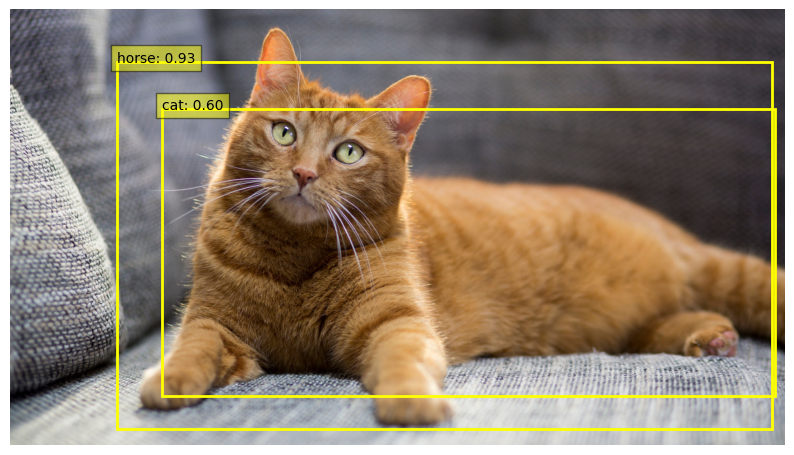

In [ ]:
predict_and_plot("assets/images/cat.png")

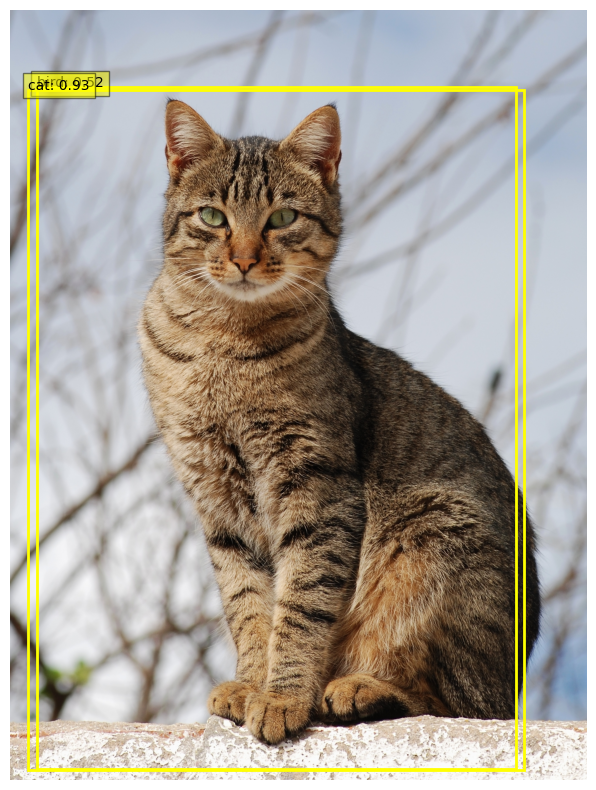

In [ ]:
predict_and_plot("assets/images/cat2.png")

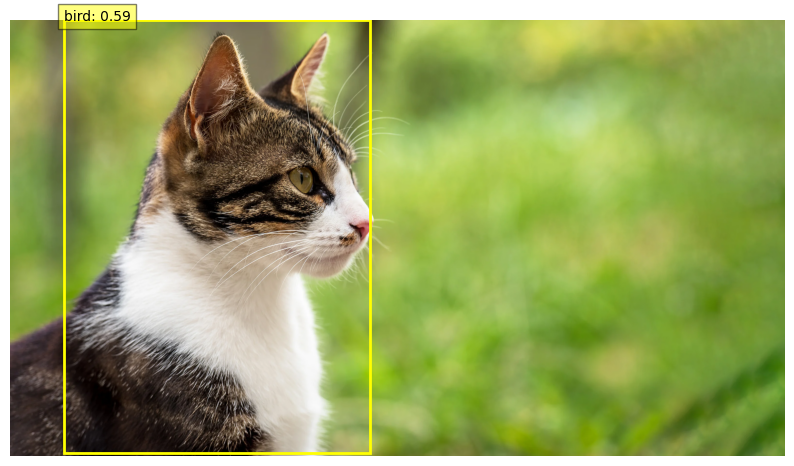

In [ ]:
predict_and_plot("assets/images/cat3.png")

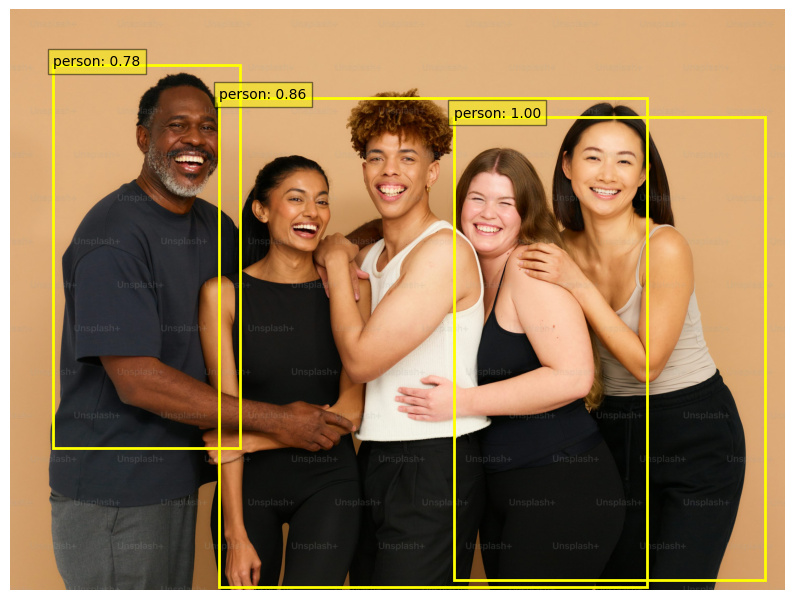

In [ ]:
predict_and_plot("assets/images/group.png")